# Use Power Curve Filtering to Identify Periods with Normal Operation

Apply several power curve filters to identify and remove periods where individual wind turbines are operating abnormally. Only periods with normal operation will be analyzed in the remainder of the examples.

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from flasc.dataframe_operations import (
    dataframe_filtering as dff,
    dataframe_manipulations as dfm,
)
from flasc.turbine_analysis import ws_pow_filtering as wspf
# from flasc import time_operations as fto

from models import load_smarteole_floris

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

In [3]:
# User settings
save_figures = True
plot_figures_in_notebook = True

# **Step 0**: Initial data pulldown
First, we import the formatted SMARTEOLE SCADA data from the postprocessed folder.

In [4]:
def load_data():
    root_path = os.getcwd()
    f = os.path.join(root_path, "postprocessed", "df_scada_60s_formatted.ftr")
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada

df_scada_formatted = load_data()

# Assume a fixed ambient turbulence intensity of 11%, as used in the SMARTEOLE experiment
df_scada_formatted["ti"] = 0.11

# **Step 1**: Filter the data for outliers
We apply a number of filtering operations here, like the removal of NaN wind speed/power measurements, negative wind speed/power measurements, irregularly high wind speed/power measurements, sensor-stuck type of faults, self-flagged faults (i.e., internal turbine status flags), and filtering based on deviations from the median windspeed-power curve.

Faulty measurements for WTG 000 increased from 3.361 % to 3.361 %. Reason: 'Wind speed and/or power is NaN'.
Faulty measurements for WTG 000 increased from 3.361 % to 3.361 %. Reason: 'Wind speed below zero'.
Faulty measurements for WTG 000 increased from 3.361 % to 17.929 %. Reason: 'Power below zero'.
Faulty measurements for WTG 000 increased from 17.929 % to 17.929 %. Reason: 'Wind speed above 50 m/s'.
Faulty measurements for WTG 000 increased from 17.929 % to 17.929 %. Reason: 'Power above 30 MW'.
Faulty measurements for WTG 000 increased from 17.929 % to 17.938 %. Reason: 'Power below 1 kW while wind speed above 4 m/s'.
Faulty measurements for WTG 000 increased from 17.938 % to 17.953 %. Reason: 'Curtailment: wind speed above 14 m/s but power below 1850 kW'.
Faulty measurements for WTG 000 increased from 17.953 % to 19.019 %. Reason: 'Self-flagged (is_operation_normal==False)'.
Faulty measurements for WTG 000 increased from 19.019 % to 19.021 %. Reason: 'Sensor-stuck fault'.
Fault

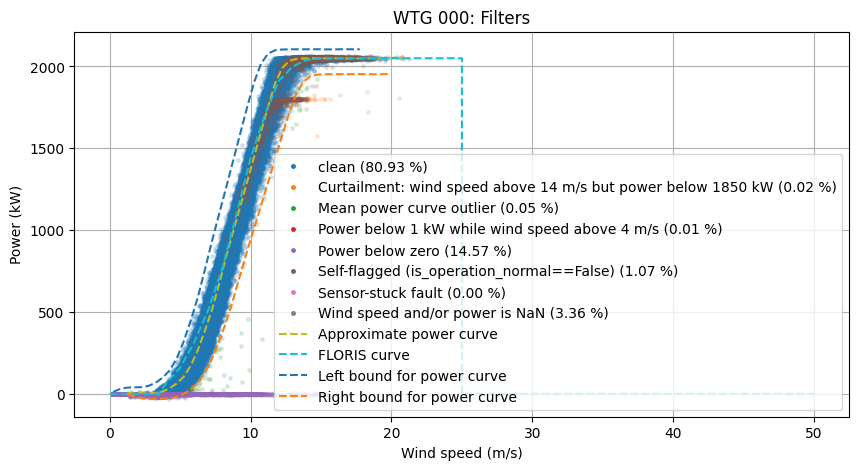

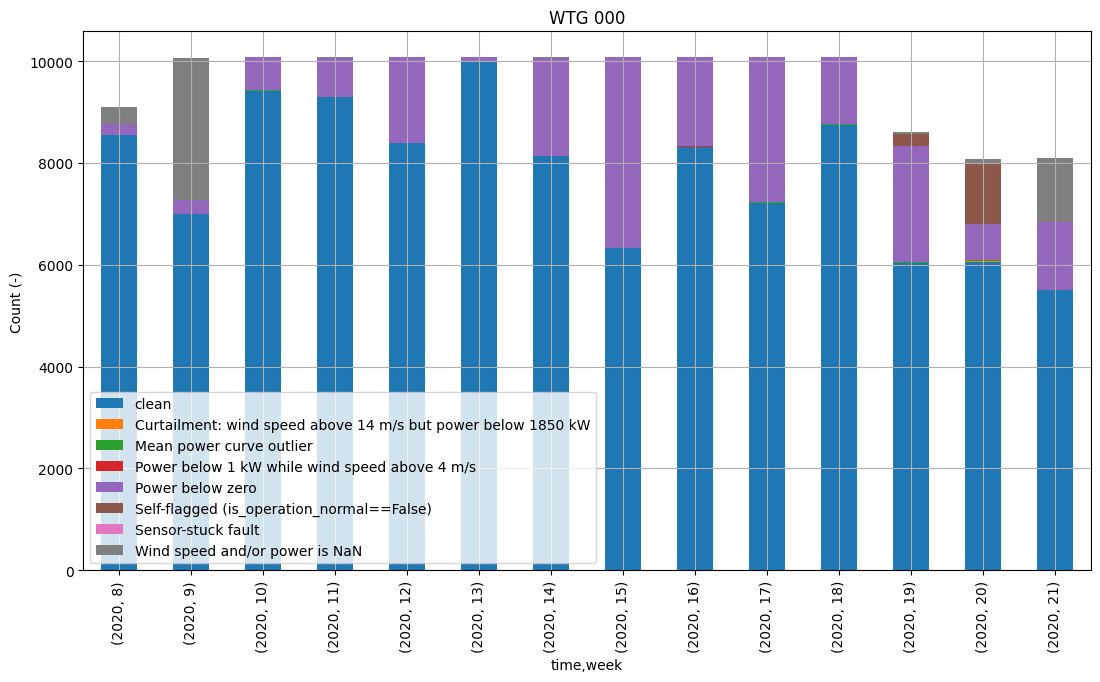

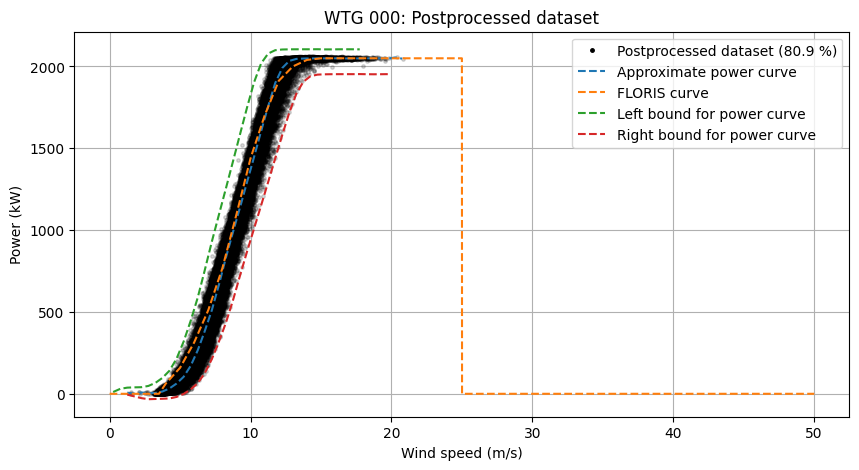

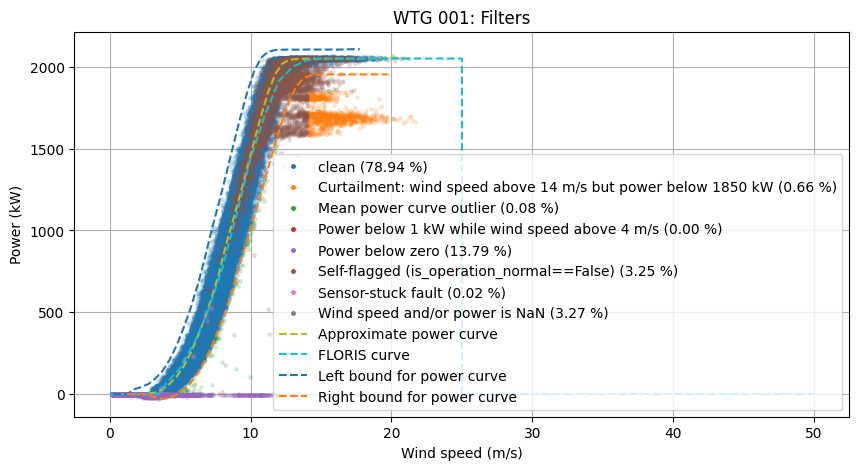

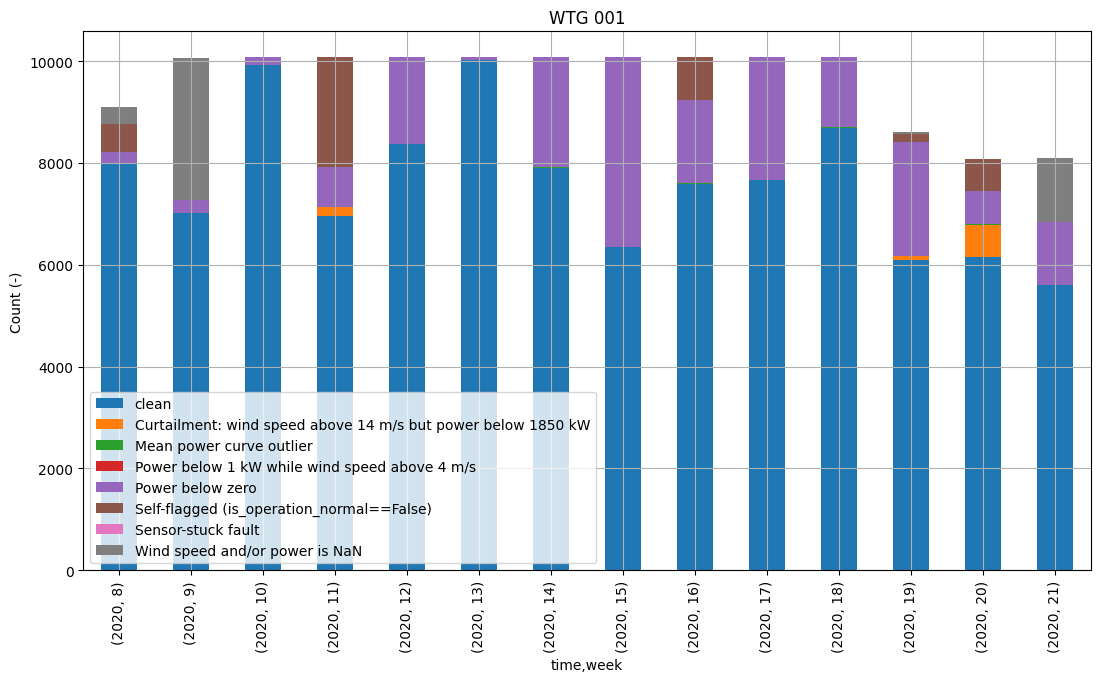

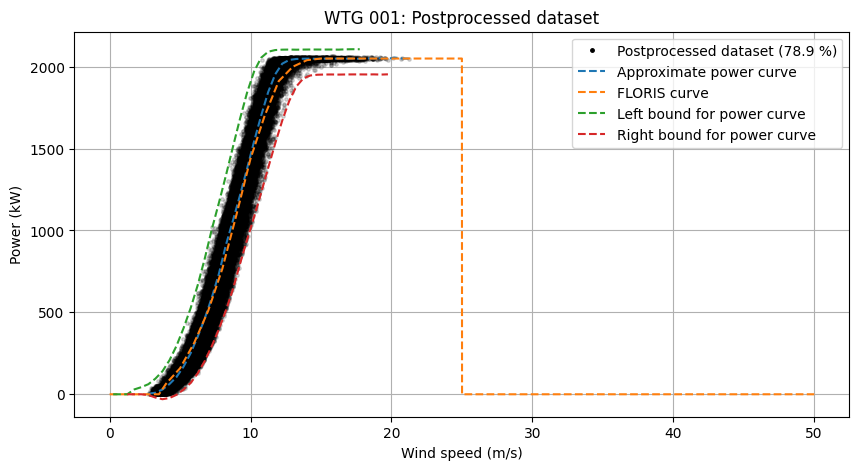

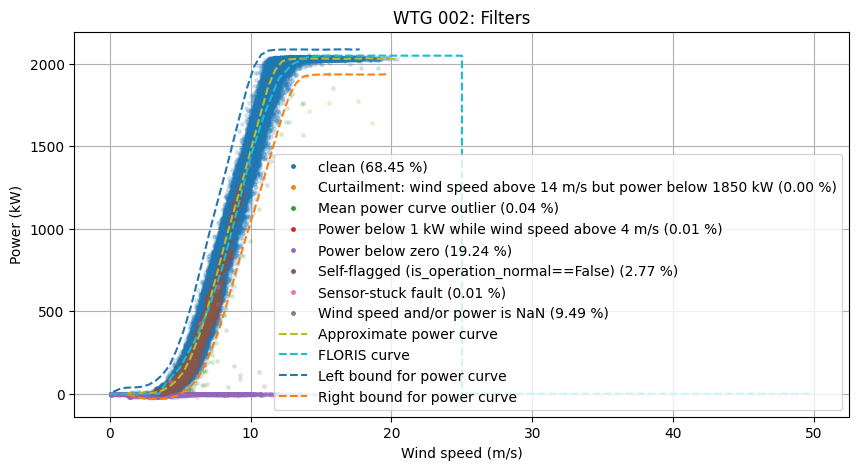

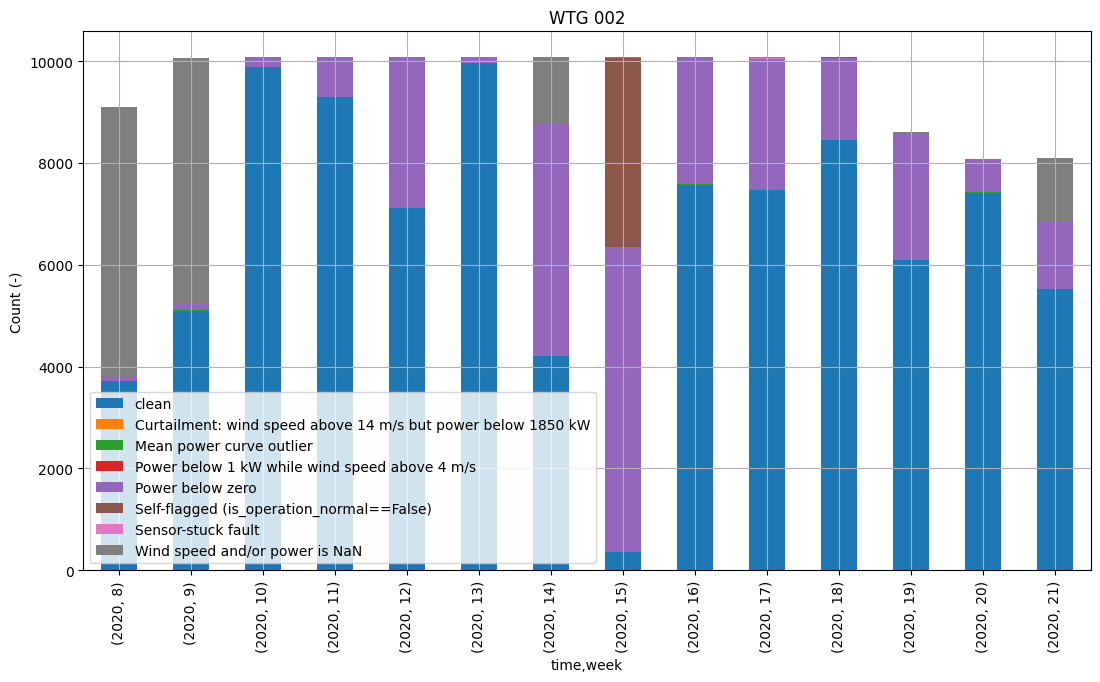

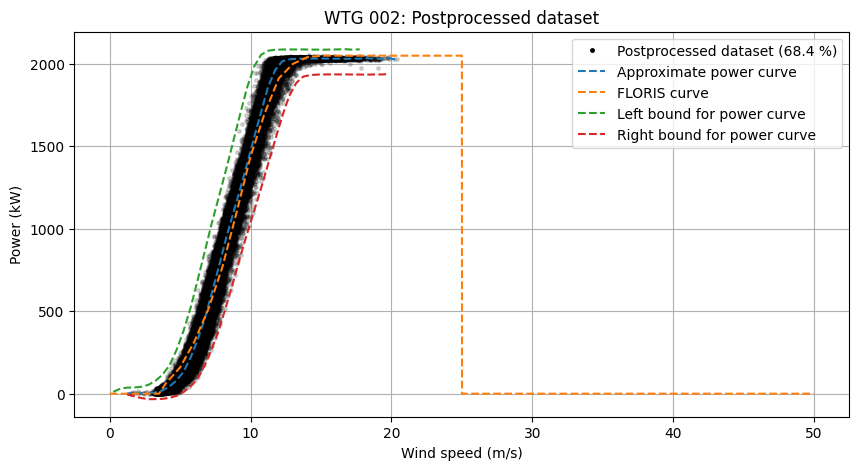

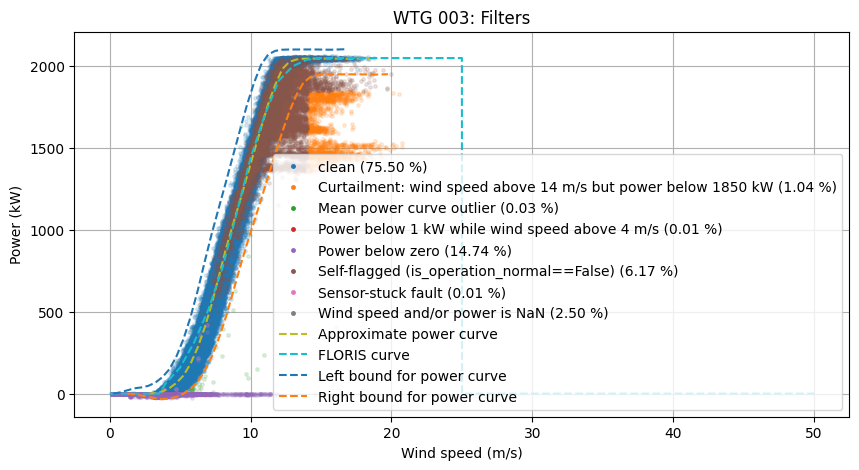

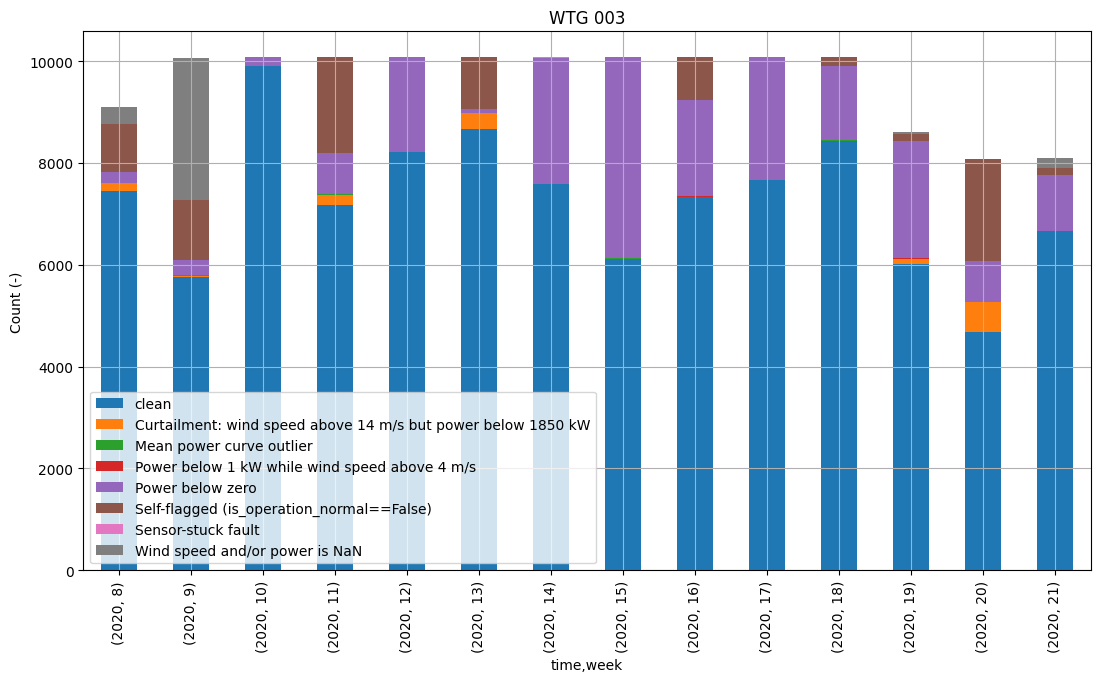

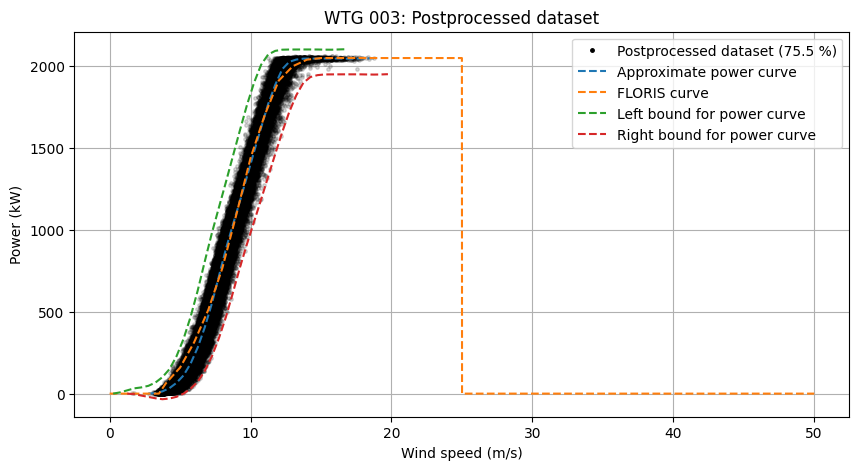

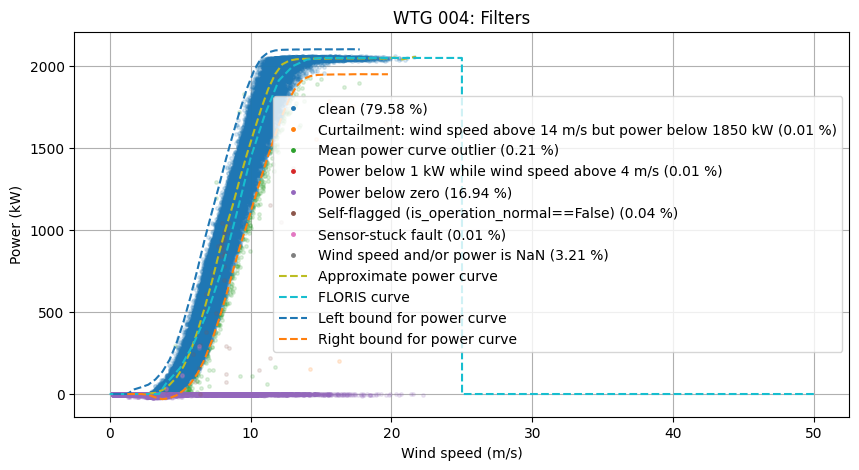

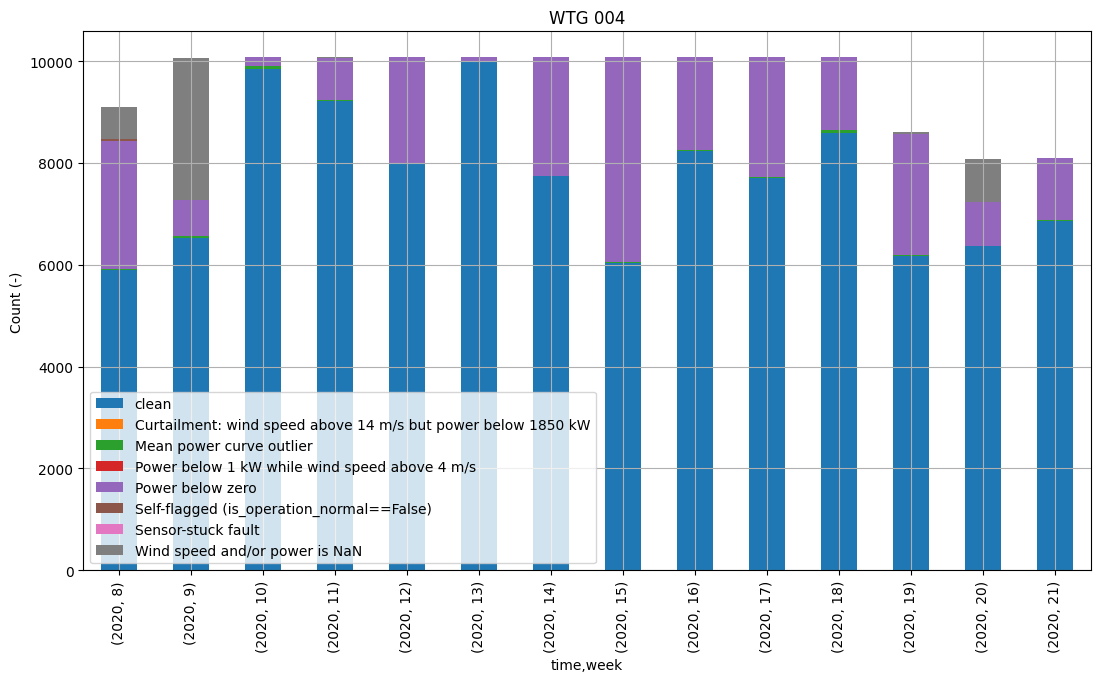

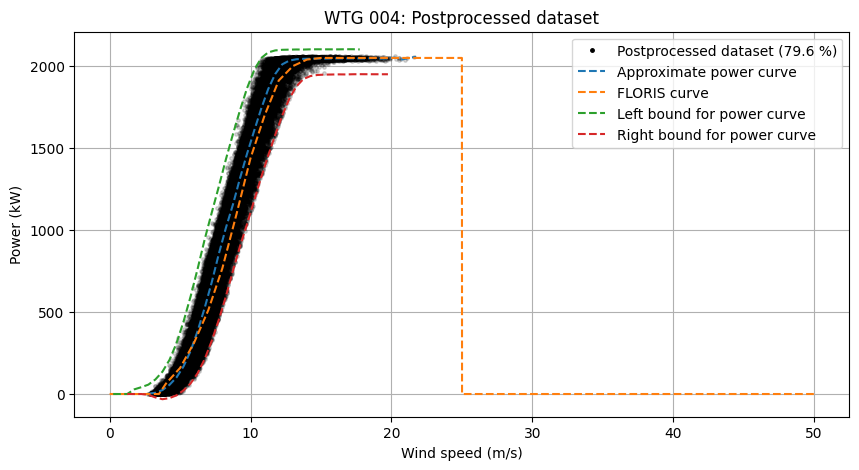

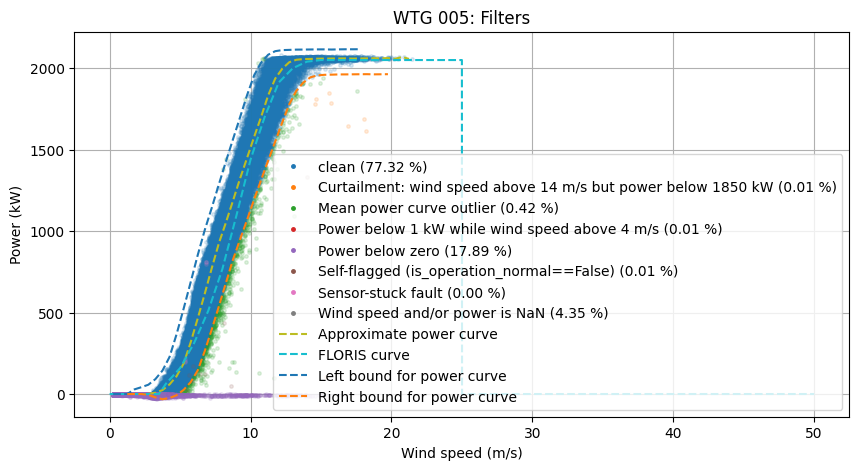

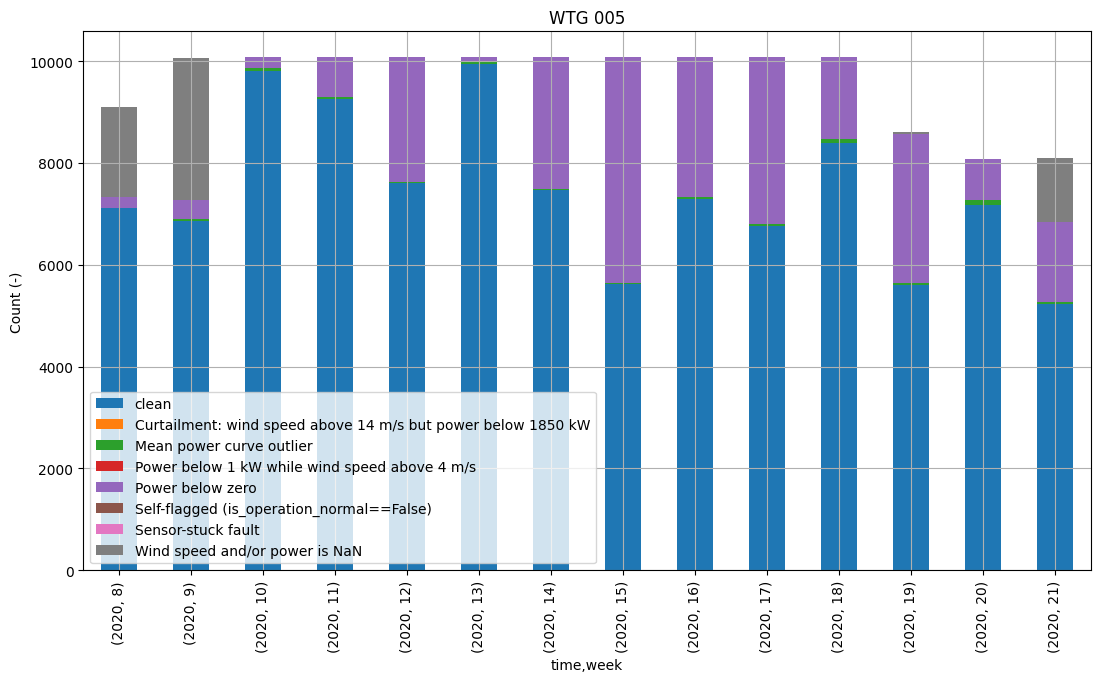

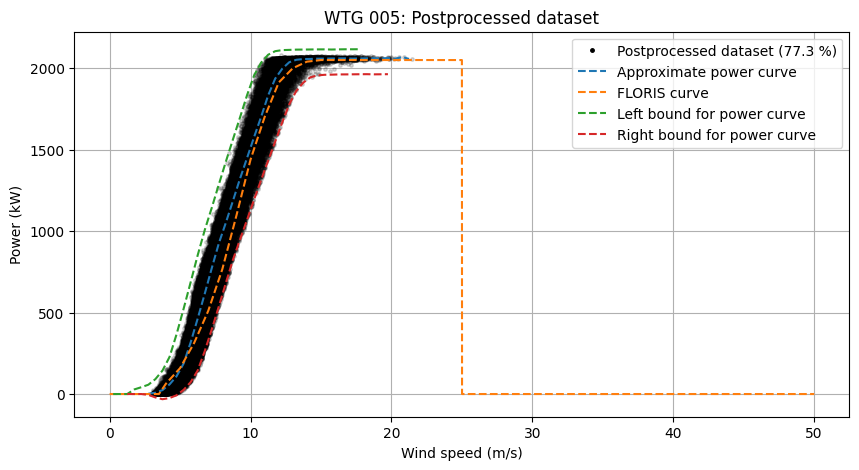

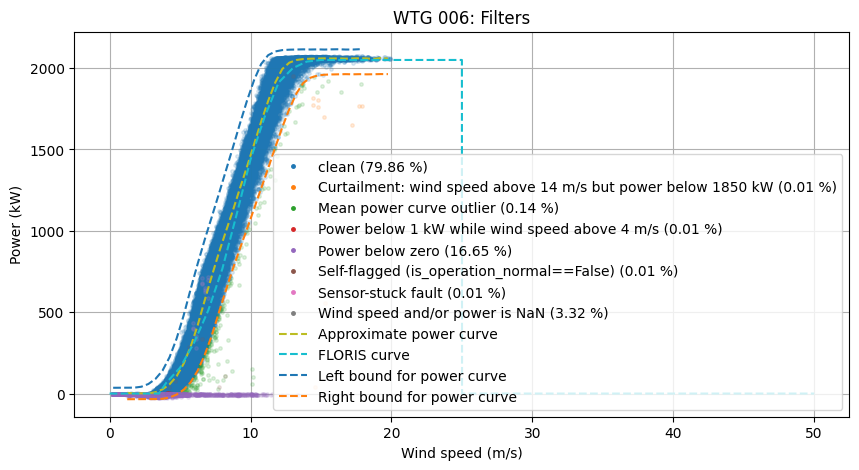

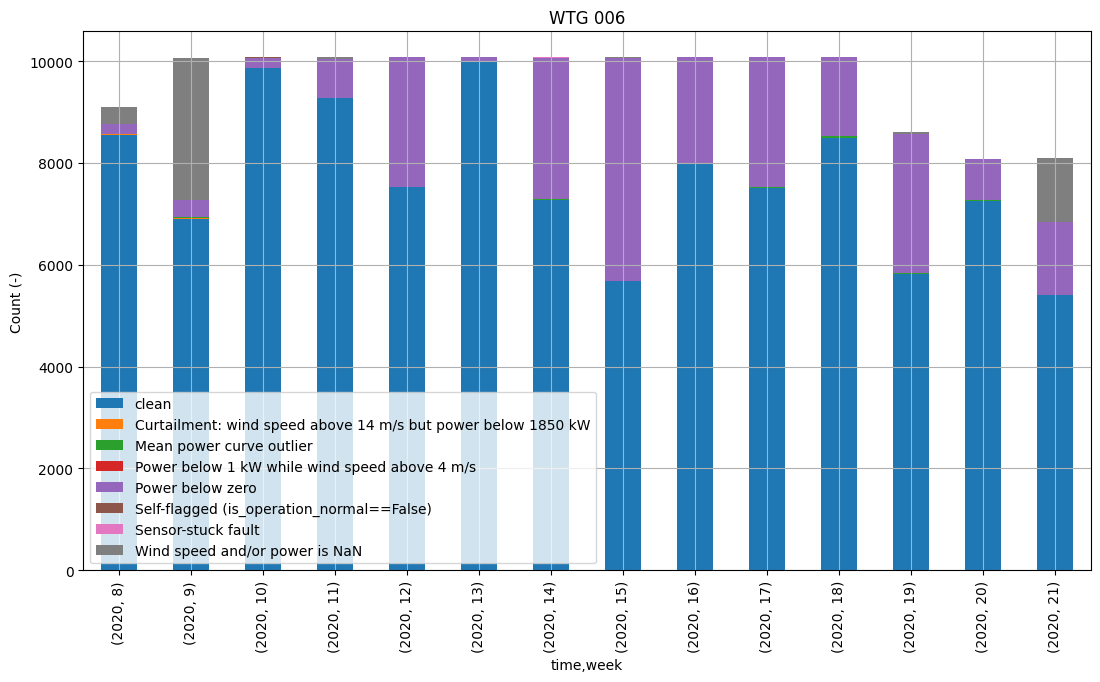

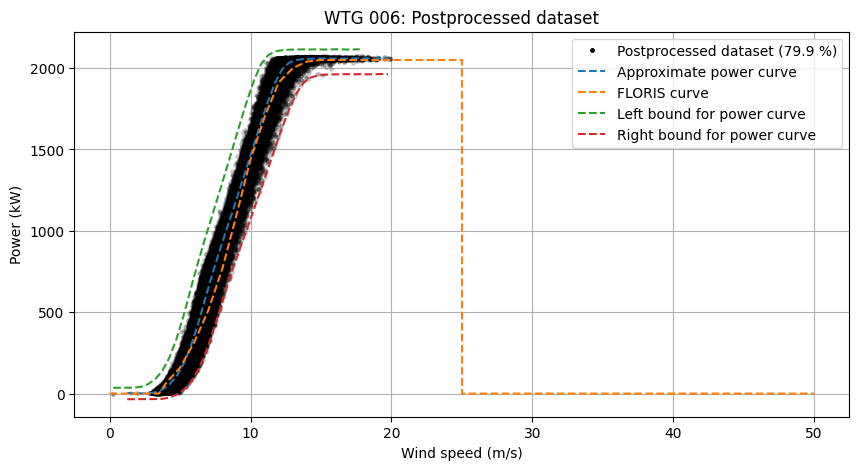

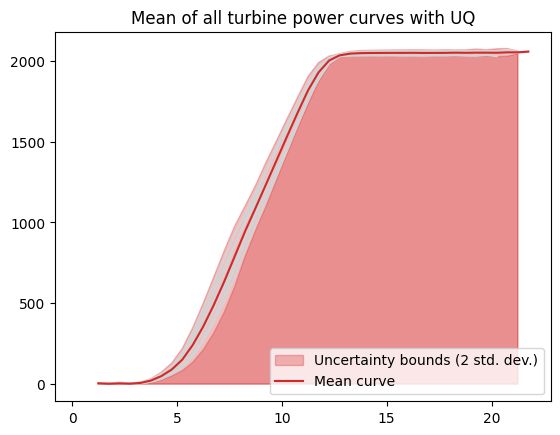

In [5]:
def filter_by_ws_pow_curve(df, plot_figures=True, save_figures=False):
    # Load the FLORIS model for the wind farm. This is not used for anything
    # besides plotting the floris-predicted wind speed-power curve on top
    # of the actual data.
    fi = load_smarteole_floris()

    # Downsample data. Not necessary here, but can be useful if we have 1 Hz
    # data available. Namely, it's hard to detect outliers on such a high
    # resolution. Instead, we are better off downsampling the data to 60s or
    # even 600s and filter the data based on decisions there. The following
    # downsampled dataframe should then be inserted into the wind speed power
    # curve filtering class. Mapping the filtering back to the high-resolution
    # data is done by a couple lines of code as found at the end of this
    # script.
    #
    # df_movavg, data_indices_mapping = top.df_movingaverage(
    #     df_in=df_1s,
    #     cols_angular=[
    #         c for c in df_1s.columns if (
    #             ("vane_" in c) or
    #             ("yaw_" in c) or
    #             ("wd_" in c) or
    #             ("direction" in c)
    #         )
    #     ],
    #     window_width=td(seconds=600),
    #     calc_median_min_max_std=False,
    #     return_index_mapping=True,
    # )

    # Create output directory
    if (plot_figures) & (save_figures):
        root_path = os.getcwd()
        figure_save_path = os.path.join(root_path, "postprocessed", "figures", "04_wspowcurve_filtered")
        os.makedirs(figure_save_path, exist_ok=True)
    else:
        figure_save_path = None

    # Initialize the wind speed power curve filtering class
    ws_pow_filtering = wspf.ws_pw_curve_filtering(df=df)

    # Apply a set of logic filters on the turbine measurements
    n_turbines = dfm.get_num_turbines(df)
    for ti in range(n_turbines):
        # Filter for NaN wind speed or power productions
        ws_pow_filtering.filter_by_condition(
            condition=(
            ws_pow_filtering.df["ws_{:03d}".format(ti)].isna() |
            ws_pow_filtering.df["pow_{:03d}".format(ti)].isna()
            ),
            label="Wind speed and/or power is NaN",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] < -1.0e-6),
            label="Wind speed below zero",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["pow_{:03d}".format(ti)] < -1.0e-6),
            label="Power below zero",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] > 50),
            label="Wind speed above 50 m/s",
            ti=ti,
            verbose=True,
        )

        # Filter for numerical issues: note, make sure power is in kW
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["pow_{:03d}".format(ti)] > 30e3),
            label="Power above 30 MW",
            ti=ti,
            verbose=True,
        )

        # Filter for power production is zero above cut-in wind speeds
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["ws_{:03d}".format(ti)] > 4.0) & (ws_pow_filtering.df["pow_{:03d}".format(ti)] < 1.0),
            label="Power below 1 kW while wind speed above 4 m/s",
            ti=ti,
            verbose=True,
        )

        # Flag curtailment by marking measurements with a high wind speed but lower power production 
        # as faulty. Note that this will only catch obvious outliers because it is difficult to 
        # identify curtailment using a single wind speed and power threshold. More sophisticated outlier 
        # conditions could be added here though.
        ws_pow_filtering.filter_by_condition(
            condition=(
                (ws_pow_filtering.df["ws_{:03d}".format(ti)] > 14.0) &
                (ws_pow_filtering.df["pow_{:03d}".format(ti)] < 1850.0)
            ),
            label="Curtailment: wind speed above 14 m/s but power below 1850 kW",
            ti=ti,
            verbose=True,
        )
        
        # Other common filters here are based on turbine-specific/OEM-specific flags. For example,
        # a 'run counter' may indicate how many seconds of a 10-minute period the turbine was
        # reporting valid measurements. By filtering for the condition that that value is 600, or
        # above 590, you should be able to quickly identify a large part of faulty measurements.
        # Similarly, you may want to look for 'turbineOK' and 'normal_operation' flag of the
        # turbine.
        #
        # Additionally, if you have blade pitch angle measurements, you may be able to filter
        # for outliers by looking when blade pitch angles exceed, e.g., 70 degrees. These filter
        # steps very much depend on the dataset that you have access to. 
        # 
        # Another useful variable is 'power setpoint', if that is available. You can use this
        # to detect and then filter for turbine curtailment (i.e., turbine setpoint lower
        # than available power on purpose). Same thing goes for derating codes, signifying
        # particular derating/curtailment behavior, power mode signals, alarm signals.
        #
        # In this case, we have an operational status flag, which we have called is_operation_normal, 
        # indicating if a turbine is oeprating normally or if it is derated or shut down. If that has 
        # a 'False' value, then we mark those measurements as faulty.
        ws_pow_filtering.filter_by_condition(
            condition=(ws_pow_filtering.df["is_operation_normal_{:03d}".format(ti)] == False),
            label="Self-flagged (is_operation_normal==False)",
            ti=ti,
            verbose=True,
        )

        # Filter for sensor-stuck faults
        ws_pow_filtering.filter_by_sensor_stuck_faults(
            columns=["wd_{:03d}".format(ti), "ws_{:03d}".format(ti)],
            ti=ti,
            n_consecutive_measurements=3,
            stddev_threshold=0.001,
            plot=False,
        )

        # Now filter iteratively by deviations from the median power curve.
        # Common reason for measurements with a low wind speed but a high power
        # production (i.e., to the left of the mean curve) is icing or dirt on the
        # wind speed sensor, or generally a the wind speed sensor being obstructed
        # in some way.
        ws_pow_filtering.filter_by_power_curve(
            ti=ti,
            ws_deadband=1.5,
            pow_deadband=70.0,
            cutoff_ws=20.0,
            m_pow_rb=0.97,
        )

        # An additional filtering step we may consider here is removing all measurements
        # directly after a NaN. The reasoning behind this is that the wind farm flow
        # may still be affected by an outlier/odd turbine behavior the 10 minutes
        # after that problem was solved, due to wake propagation delays.
        # Note that this doubles the number of NaNs in your dataset and thereby decreases
        # the useful data pool. In this example, we decide not to filter for that.

        # Plot and save data for current dataframe
        ws_pow_filtering.plot_filters_in_ws_power_curve(ti=ti, fi=fi)
        ws_pow_filtering.plot_filters_in_time(ti=ti)
        ws_pow_filtering.plot_postprocessed_in_ws_power_curve(ti=ti, fi=fi)
        print("\n")

    # Plot farm-averaged power curve based on the data (useful to e.g., feed into FLORIS when not provided by OEM)
    ws_pow_filtering.plot_farm_mean_power_curve()

    # Get filtered dataframe and power curve
    df = ws_pow_filtering.get_df()
    df_pow_curve = ws_pow_filtering.pw_curve_df

    return df, df_pow_curve


df_scada_filtered, df_pow_curve = filter_by_ws_pow_curve(
    df=df_scada_formatted.copy()
)

# **Step 2**: Plot faults vs. the layout
Next, let's plot the wind plant layout with the percentage of the data set remaining after removing abnormal data indicated.

Saving figure to figures/01_filter_ws_power_curves/faults_by_layout.png.


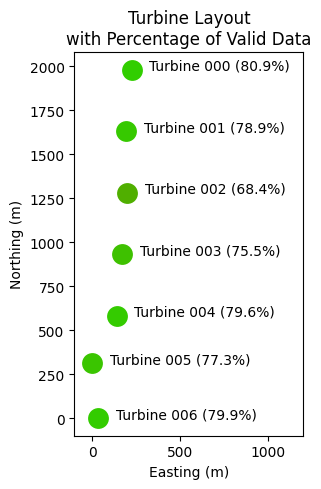

In [6]:
def plot_faults_vs_layout(df):
    fi = load_smarteole_floris()

    layout_x = fi.layout_x
    layout_y = fi.layout_y

    num_turbines = dfm.get_num_turbines(df)
    fault_ratio = np.zeros(num_turbines)
    for ti in range(num_turbines):
        fault_ratio[ti] = (
            dff.df_get_no_faulty_measurements(df, ti) / df.shape[0]
        )

    # Plot layout and colormap
    fig, ax = plt.subplots(figsize=(14, 5))
    for ti in range(num_turbines):
        clr = [fault_ratio[ti], 1.0 - fault_ratio[ti], 0.0]
        ax.plot(
            layout_x[ti],
            layout_y[ti],
            "o",
            markersize=15,
            markerfacecolor=clr,
            markeredgewidth=0.0,
        )
        ax.text(
            layout_x[ti] + 100,
            layout_y[ti],
            "Turbine %03d (%.1f%%)" % (ti, (1.0 - fault_ratio[ti]) * 100.0),
            color="black",
        )
        ax.set_xlim([-100, 1200])
    ax.set_aspect('equal')
    ax.set_ylabel("Northing (m)")
    ax.set_xlabel("Easting (m)")
    ax.set_title("Turbine Layout\nwith Percentage of Valid Data")
    fig.tight_layout()

    root_path = os.getcwd()
    out_path = os.path.join(
        root_path,
        "figures",
        "01_filter_ws_power_curves",
    )
    fig_out = os.path.join(out_path, "faults_by_layout.png")
    print("Saving figure to {:s}.".format(os.path.relpath(fig_out)))
    os.makedirs(out_path, exist_ok=True)
    plt.savefig(fig_out, dpi=300)

plot_faults_vs_layout(df_scada_filtered)

# **Step 3**: Save postprocessed data to a local file
Lastly, we'll save the filtered SCADA data frame locally. This data frame will be used as the starting point in the next example notebook.

In [7]:
root_path = os.getcwd()
fout = os.path.join(root_path, "postprocessed", "df_scada_60s_wspowfiltered.ftr")
df_scada_filtered.to_feather(fout)
print("File saved to '{:s}'.".format(os.path.relpath(fout)))

File saved to 'postprocessed/df_scada_60s_wspowfiltered.ftr'.
